<a href="https://colab.research.google.com/github/JMQuinones/easylock-extras/blob/master/face_recog_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de reconocimiento facial



# 1. Importar librerias y funciones auxiliares





In [ ]:
!pip install pillow
!pip install --upgrade pip
!pip install 'keras<3.0.0' mediapipe-model-maker
!pip install -q mediapipe
!pip install keras

In [ ]:
import os
import math

import tensorflow as tf
import matplotlib.pyplot as plt
from mediapipe_model_maker import image_classifier

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python.components import processors
from mediapipe.tasks.python import vision
import cv2

from google.colab.patches import cv2_imshow
from google.colab import drive


In [ ]:
# Obtenido de https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/image_classification/python/image_classifier.ipynb#scrollTo=TUfAcER1oUS6
# Bajo la licencia Apache 2.0
from matplotlib import pyplot as plt
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(images, predictions):
    """Displays a batch of images with the classifications."""
    # Images and predictions.
    images = [image.numpy_view() for image in images]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 7.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display.
    for i, (image, prediction) in enumerate(zip(images[:rows*cols], predictions[:rows*cols])):
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        subplot = display_one_image(image, prediction, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

# 2. Pre-procesamiento

##  2.1 Cargar el conjunto de datos

In [ ]:
drive.mount('/content/drive')

In [ ]:
!unzip 'drive/MyDrive/Colab Notebooks/mediapipe/dataset.zip' -d .

In [ ]:
!unzip 'drive/MyDrive/Colab Notebooks/mediapipe/test_dataset.zip' -d .


In [ ]:
image_path = os.path.join(os.path.dirname('.'), 'dataset')
test_path = os.path.join(os.path.dirname('.'), 'test_dataset')

##2.2 Crear los conjuntos de datos

Primero verificamos las etiquetas (labels) de los datos






In [ ]:
print(image_path)
labels = []
for i in os.listdir(image_path):
  if os.path.isdir(os.path.join(image_path, i)):
    labels.append(i)
print(labels)

Existen dos etiquetas:
 * positive. Para las imagenes positivas
 * negative. Para las imagenes negativas

Ejemplos de imagenes positivas y negativas

In [ ]:
NUM_EXAMPLES = 5

%matplotlib inline
for label in labels:
  label_dir = os.path.join(image_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  plot_label = 'positivas' if label == 'positive' else 'negativas'
  fig.suptitle(f'{NUM_EXAMPLES} ejemplos de imagenes {plot_label}')
plt.show()

Se carga todas las imagenes desde un directorio y se crea tres conjuntos de datos:
  * train_data. El conjunto de entrenamiento que consta del 70% de los datos
  * validation_data. Utilizado para la validacion al momento de realizar el entrenamiento, que posee el 30% de los datos
  * test_data. 1000 imagenes (500 por clase) para realizar las pruebas del modelo.

In [ ]:
data = image_classifier.Dataset.from_folder(image_path)
train_data, validation_data = data.split(0.7)
test_data = image_classifier.Dataset.from_folder(test_path)

In [ ]:
print(f"train_data size {train_data.size} validation_data size {validation_data.size} test_data size {test_data.size}")

# 3. Entrenamiento del modelo
El framework "MediaPipe" utiliza la tecnica conocida como Transfer learning para re-entrenar un modelo existente con nuestros propios datos. Esto permite entrenar modelos de ML de forma mas rapida y precisa.

##3.1 Configurar el modelo

El primer paso es configurar los parametros que se utilizaran en el entrenamiento, incluyendo el numero de epocas (epochs) o la arquitectura del modelo que se utilizara.


In [ ]:
# Modelo a utilizar
spec = image_classifier.SupportedModels.MOBILENET_V2
# Directorio para guardar el modelo
export_dir="exported_model"

In [ ]:
# 10 epocas, aleatorizacion, deshabilitar data augmentation
hparams=image_classifier.HParams(epochs=10, export_dir=export_dir, shuffle=True, do_data_augmentation=False)
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)
options.model_options = image_classifier.ModelOptions(dropout_rate = 0.2)

##3.2. Entrenar

In [ ]:
model = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = validation_data,
    options=options,
)

In [ ]:
model.summary()

# 4. Exportar el modelo
Para poder utilizar el modelo en una aplicacion movil, debe convertirse a un modelo tipo *tflite*.
MediaPipe ofrece metodos para exportar el modelo, junto con todos los metadatos necesarios.

In [ ]:
model.export_model()

In [ ]:
!ls exported_model

# 5. Validacion del modelo

In [ ]:
model_path = os.path.join(os.path.dirname('.'), 'exported_model','model.tflite')

## 5.1. Verificacion con imagenes de prueba
Verificamos las predicciones del modelo con imagenes aleatorias, para comprobar que se realiza un clasificacion **adecuada**

In [ ]:
image_paths = [
    '/content/test_dataset/positive/IMG_20240401_101103.jpg',
    '/content/test_dataset/negative/Paul_Bremer_0001.jpg',
    '/content/test_dataset/negative/Robert_Duvall_0001.jpg',
    '/content/test_dataset/negative/Robert_Mugabe_0001.jpg',
    '/content/test_dataset/negative/Rod_Stewart_0002.jpg',
    '/content/test_dataset/negative/Roger_Moore_0003.jpg',
    '/content/test_dataset/positive/18dc6425-9986-434b-9718-02de6a2cf9e0.jpg',
    '/content/test_dataset/positive/7e7dc56d-4317-4a06-a453-be68e3ade492.jpg',
    '/content/test_dataset/positive/ed77614e-f1c6-11ee-b4b8-309c233d13a3.jpg'
    ]

In [ ]:
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.ImageClassifierOptions(
    base_options=base_options, max_results=9)
classifier = vision.ImageClassifier.create_from_options(options)

images = []
predictions = []
for image_name in image_paths:
  image = mp.Image.create_from_file(image_name)

  classification_result = classifier.classify(image)

  images.append(image)
  top_category = classification_result.classifications[0].categories[0]
  predictions.append(f"{top_category.category_name} ({top_category.score:.2f})")

display_batch_of_images(images, predictions)

## 5.2. Matriz de confusion
Es una visualizacion del rendimiento de un modelo, indica qué tipos de aciertos y errores está teniendo nuestro modelo a la hora de pasar por el proceso de aprendizaje con los datos.

Esta compuesta por:
* Verdaderos positivos
* Verdaderos negativos
* Falsos positivos
* Falsos negativos

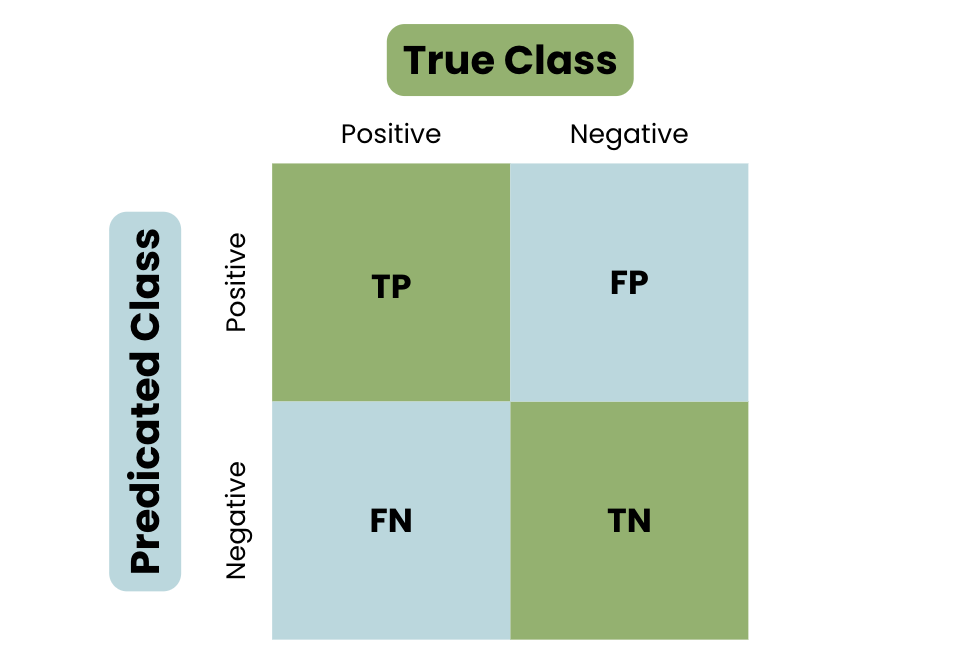

### 5.2.1. Obtener los parametros para la matriz

In [ ]:
fn_images = []
fp_images = []

In [ ]:
# Realiza la prediccion de un arreglo de imagenes devolviendo las etiquetas
# correspontiendes
def get_predictions(images_array, path, false_array):
  prediction_labels = []
  for image_name in images_array:
    image_path = os.path.join(path, image_name)
    input_image = mp.Image.create_from_file(image_path)
    classification_result = classifier.classify(input_image)
    top_category = classification_result.classifications[0].categories[0]
    if top_category.score < 0.90:
      top_category = classification_result.classifications[0].categories[1]
      false_array.append(image_path)
    prediction_labels.append(top_category.category_name)
  return prediction_labels

In [ ]:
positive_test_path = os.path.join(test_path,'positive')

In [ ]:
negative_test_path = os.path.join(test_path,'negative')

In [ ]:
positive_test_images = os.listdir(positive_test_path)
negative_test_images = os.listdir(negative_test_path)

In [ ]:
positive_labels = get_predictions(positive_test_images, positive_test_path, fn_images)

In [ ]:
tp = positive_labels.count('positive')
fn = len(positive_labels) - tp

In [ ]:
negative_labels = get_predictions(negative_test_images, negative_test_path, fp_images)

In [ ]:
tn = negative_labels.count('negative')
fp = len(negative_labels) - tn

In [ ]:
print(f'Verdaderos positivos {tp} Falsos negativos: {fn}')

In [ ]:
print(f'Verdaderos negativos {tn} Falsos positivos: {fp}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

matrix = np.array([[tp, fp],
                   [fn, tn]])

plt.imshow(matrix, cmap='GnBu', interpolation='nearest')

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, str(matrix[i, j]), ha='center', va='center', color='gray')

plt.colorbar()
plt.xlabel('Valores reales')
plt.ylabel('Valores predecidos')
plt.title('Matriz de confusion')

plt.show()


### 5.2.2. Metricas de clasificacion


#### Exactitud. Porcentaje de predicciones correctas en base al total. TP + TN / TP + TN + FP + FN

In [ ]:
exac= (tp + tn) / (tp + tn + fp + fn)
print(f"Exactitud = {exac:.2%}")

#### Precision.  Se refiere a lo cerca que está el resultado de una predicción del valor verdadero. TP / TP + FP

In [ ]:
pre = tp / (tp + fp)
print(f"Precision = {pre:.2%}")

#### Sensibilidad. Es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo. TP / (TP + FN)

In [ ]:
sens = tp / (tp + fn)
print(f"Sensibilidad = {sens:.2%}")

#### Especificidad. Se trata de los casos negativos que el algoritmo ha clasificado correctamente. Expresa cuan bien puede el modelo detectar esa clase. TN / TN + FP

In [ ]:
esp = tn / (tn + fp)
print(f"Especifidad = {esp:.2%}")

#### Tasa de clasificación errónea. Representa la cantidad de clasificaciones incorrectas obtuvo el modelo. FP + FN / TP + TN + FP + FN

In [ ]:
tce = (fp + fn) / (tp + tn + fp + fn)
print(f"Tasa de clasificacion erronea = {tce:.2%}")